In [1]:
import re
from datetime import datetime
from pathlib import Path

import numpy as np
from eotransform_pandas.filesystem.gather import gather_files
from eotransform_pandas.filesystem.naming.geopathfinder_conventions import yeoda_naming_convention
from openeo.local import LocalConnection
from openeo.processes import ProcessBuilder, array_element, add, multiply, sin, cos, mask, exp

ROOT_DATA = ""

hparam_id = f"{ROOT_DATA}openEO_local/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R1/EQUI7_EU020M/E051N015T3/A044.nc"
plia_id = f"{ROOT_DATA}openEO_local/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E051N015T3/PLIA-TAG-MEAN_20200101T000000_20201231T235959__A044_E051N015T3_EU020M_V01R03_S1IWGRDH.nc"
sig0_id = f"{ROOT_DATA}openEO_local/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E051N015T3/SIG0_20180102T165837__VV_A044_E051N015T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.nc"

HPARAM_ROOT = Path(f"{ROOT_DATA}/openEO_local/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R1/EQUI7_EU020M/E051N015T3")
PLIA_ROOT = Path(f"{ROOT_DATA}/openEO_local/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E051N015T3")
SIG0_ROOT = Path(f"{ROOT_DATA}/openEO_local/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E051N015T3")

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


In [2]:
local_connection = LocalConnection([HPARAM_ROOT.as_posix(), PLIA_ROOT.as_posix(), SIG0_ROOT.as_posix()])

In [3]:
hparam_dc = local_connection.load_collection(hparam_id)
plia_dc = local_connection.load_collection(plia_id)
sig0_dc = local_connection.load_collection(sig0_id)

In [4]:
def harmonic_expected_backscatter(data, dtime_str):    
    # TODO: solve the context passing
    w = np.pi * 2 / 365
    dt = datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday  # TODO: solving day-of-year calculation
    wt = w * t

    M0 = data.band('M0')
    S1 = data.band('S1')
    S2 = data.band('S2')
    S3 = data.band('S3')
    C1 = data.band('C1')
    C2 = data.band('C2')
    C3 = data.band('C3')
    
    # NOBS = data.band('NOBS')
    # mask = NOBS >= 32
    
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2*wt)) + C2 * np.cos(2*wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3*wt)) + C3 * np.cos(3*wt))
    return hm_c3.add_dimension('bands', 'hbsc', 'bands')


def water_backscatter(plia_dc):
    return (plia_dc * -0.394181 + -4.142015).reduce_bands('mean').add_dimension('bands', 'wbsc', 'bands')


def bayesian_flood_decision(x: ProcessBuilder) -> ProcessBuilder:
    nf_std = 2.754041
    sig0 = x.array_element(index=0)
    std = x.array_element(index=1)
    wbsc = x.array_element(index=2)
    hbsc = x.array_element(index=3)
    
    f_prob = (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp((sig0 - wbsc) / (std ** 2))
    nf_prob = (1.0 / (nf_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (((sig0 - hbsc) / nf_std) ** 2))
    evidence = (nf_prob * 0.5) + (f_prob * 0.5)
    f_post_prob = (f_prob * 0.5) /  evidence 
    nf_post_prob = (nf_prob * 0.5) /  evidence 
    
    # flood if flood class has higher probability
    return f_post_prob > nf_post_prob

In [5]:
expected_bsc_dc = harmonic_expected_backscatter(hparam_dc, '2018-01-02')
water_bsc_dc = water_backscatter(plia_dc)
std_dc = hparam_dc.band('STD').add_dimension('bands', 'std', 'bands')
sig0_dc = sig0_dc.reduce_bands('mean').add_dimension('bands', 'sig0', 'bands')

In [6]:
decision_in = sig0_dc.merge_cubes(std_dc).merge_cubes(water_bsc_dc).merge_cubes(expected_bsc_dc)

In [7]:
flood_map = decision_in.reduce_bands(bayesian_flood_decision).execute()

/home/braml/code/eodc/openeo-flood-mapper-local/venv/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/braml/code/eodc/openeo-flood-mapper-local/venv/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: overflow encountered in exp
  return func(*(_execute_task(a, cache) for a in args))
/home/braml/code/eodc/openeo-flood-mapper-local/venv/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


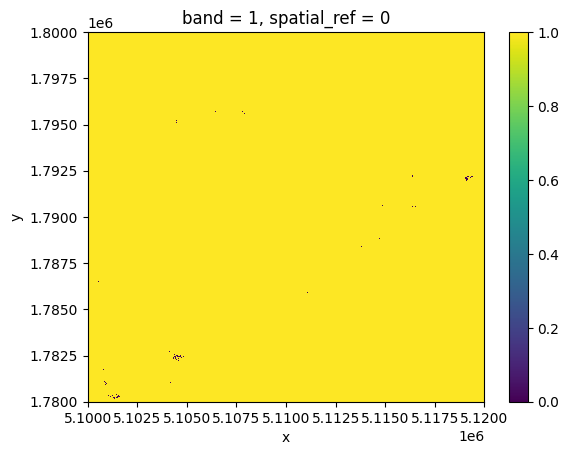

In [8]:
flood_map[:1000, :1000].plot.imshow()

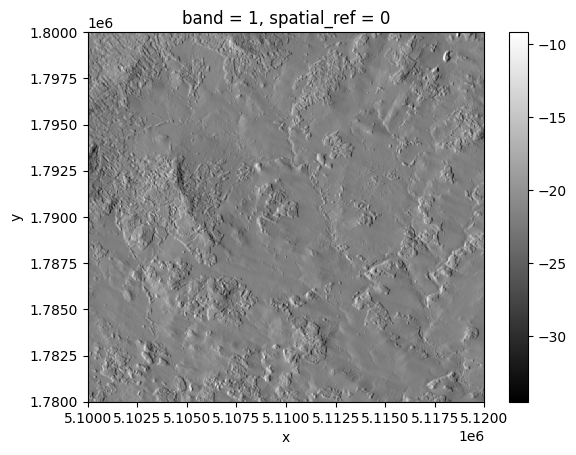

In [11]:
water_bsc_dc.band(0).execute()[:1000, :1000].plot.imshow(cmap='gray')

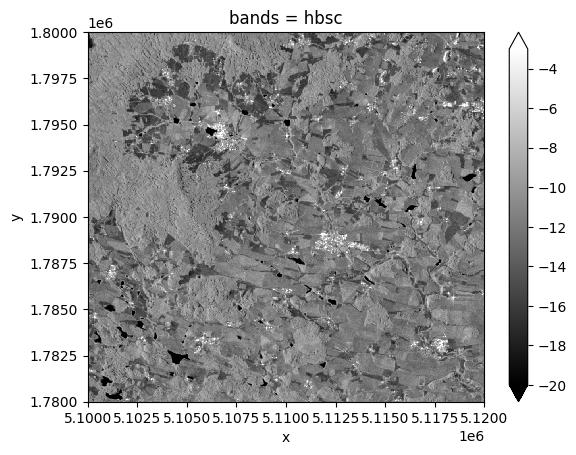

In [13]:
exp_bsc = expected_bsc_dc.execute()[0, :1000, :1000].plot.imshow(vmin=-20, vmax=-3, cmap='gray')

## Data tests

In [4]:
m0 = hparam_dc.band('M0').execute()

In [6]:
m0 = m0.load()

In [6]:
m0.dtype

dtype('float64')

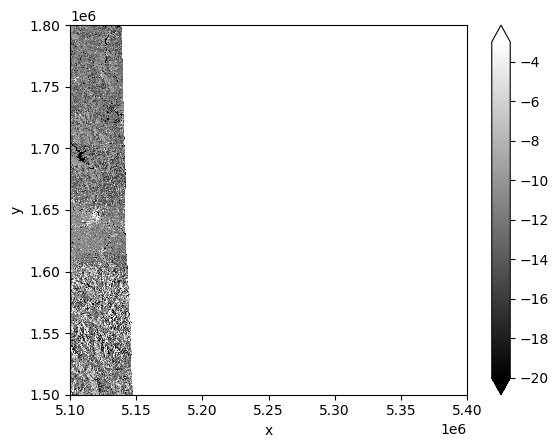

In [7]:
m0.squeeze().plot.imshow(vmin=-20, vmax=-3, cmap='gray')